In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

*Reading the datasets and exploring the data*

In [2]:
obs = pd.read_csv('observations.csv')
species = pd.read_csv('species_info.csv')

obs.head()
obs.info()
obs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB


,observations
count,23296.000000
mean,142.287904
std,69.890532
min,9.000000
25%,86.000000
50%,124.000000
75%,195.000000
max,321.000000


In [3]:
species.head()
species.info()
species.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


,category,scientific_name,common_names,conservation_status
count,5824,5824,5824,191
unique,7,5541,5504,4
top,Vascular Plant,Castor canadensis,Brachythecium Moss,Species of Concern
freq,4470,3,7,161


*Looking at the species column we can see that a lot of the species are NaN values. We will change this to "No Status" in order to include in analysis*

In [4]:
species["conservation_status"] = species["conservation_status"].fillna("No Status")
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Status
1,Mammal,Bos bison,"American Bison, Bison",No Status
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Status
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Status
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Status


*Next I will begin exploring the species dataset and begin gathering some analysis*

- Starting with the category column, I will gather the value counts and unique numbers
- I will also look at the counts of conservation status



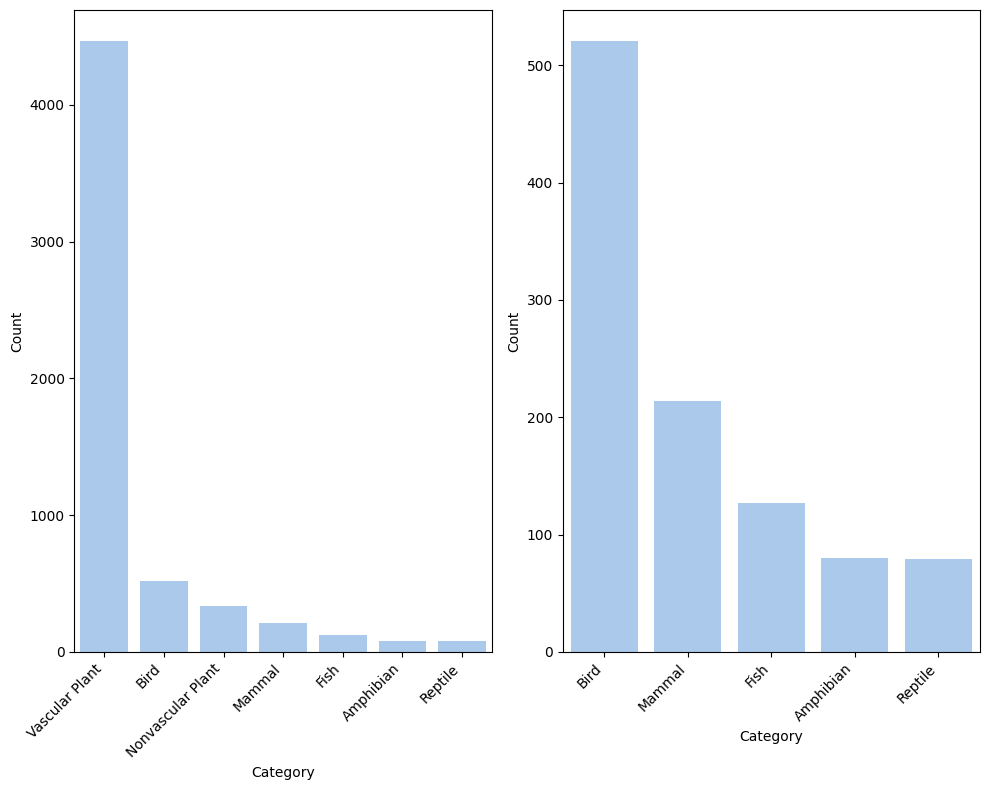

In [5]:
species["category"].value_counts()
species["category"].nunique() # < -- This confirms the value counts account for all values in the column

# I will visualise the count of each category in the species dataframe
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
sns.set_color_codes("pastel")
order_proportion = species["category"].value_counts(normalize=True)
order_cat = order_proportion.index
sns.countplot(data=species, x="category", color="b", order=order_cat)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Category")
plt.ylabel("Count")

# I will remove the plant category from the species dataframe to further detail the values in the other categories
plt.subplot(1, 2, 2)
species_animal = species[(species["category"] != "Vascular Plant") & (species["category"] != "Nonvascular Plant")]
order_proportion = species_animal["category"].value_counts(normalize=True)
order_cat = order_proportion.index
sns.countplot(data=species_animal, x="category", color="b", order=order_cat)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Category")
plt.ylabel("Count")
#Create space between the plot and the x-axis label
plt.tight_layout()
plt.show()

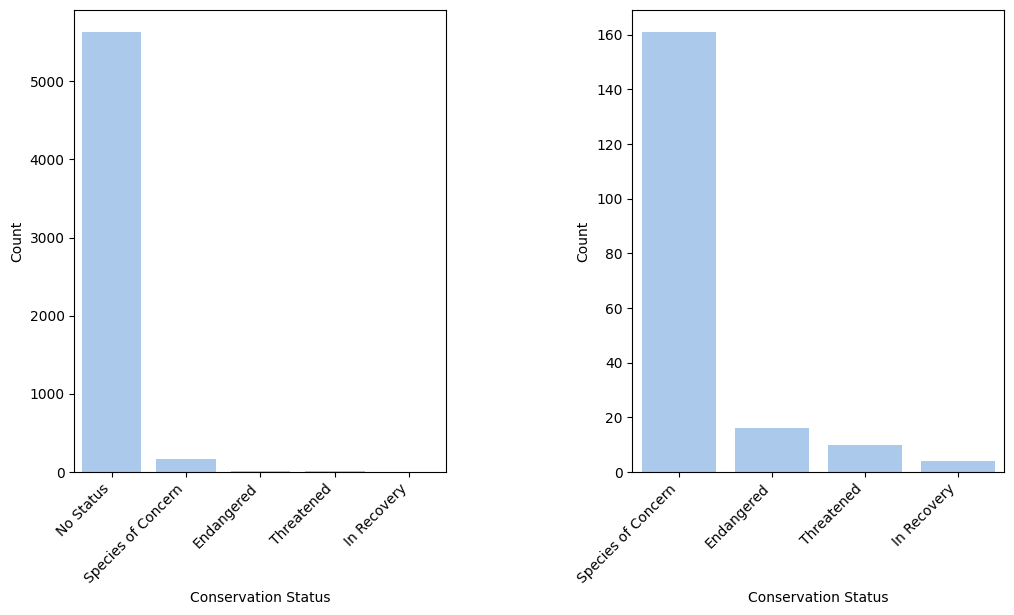

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.set_color_codes("pastel")
order_proportion = species["conservation_status"].value_counts(normalize=True)
order_cat = order_proportion.index
sns.countplot(data=species, x="conservation_status", color="b", order=order_cat)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Conservation Status")
plt.ylabel("Count")

# I will show the proportion where the conservation status is not equal to "No Status"
plt.subplot(1,2,2)
sns.set_color_codes("pastel")
no_status = species[species["conservation_status"] != "No Status"]
order_proportion = no_status["conservation_status"].value_counts(normalize=True)
order_cat = order_proportion.index
sns.countplot(data=no_status, x="conservation_status", color="b", order=order_cat)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Conservation Status")
plt.ylabel("Count")
# create space between the two plots
plt.subplots_adjust(wspace=0.5)
plt.show()

*Plants have the highest count, but in order to ascertain the level of endargedness, I will explore how many plants are endangered.*

In [7]:
plant_df = species[(species["category"] == "Vascular Plant") | (species["category"] == "Nonvascular Plant")]

plant_df["conservation_status"].value_counts(normalize=True)


conservation_status
No Status             0.989382
Species of Concern    0.009994
Threatened            0.000416
Endangered            0.000208
Name: proportion, dtype: float64

*98% of Plants do not have an endangered status. As plants represent such a large proportion of the dataset, I will remove them from further analysis of endangered categories in order to perform separate analysis of plants later on if required.*

- I will take a deeper look at the endangered list, removing the non-status values and the in-recovery, to only look at values which are endangered
- From there, I will look at what proportions are the most endangered and to what degree

In [8]:
endangered_list = ["Species of Concern", "Endangered", "Threatened"]
non_plant_df = species[(species["category"] != "Vascular Plant") & (species["category"] != "Nonvascular Plant")]
endangered = (non_plant_df[non_plant_df["conservation_status"].isin(endangered_list)])

end_count = endangered.groupby(["conservation_status", "category"]).count()["scientific_name"].unstack().fillna(0)
end_prop = (end_count/len(endangered)).round(2) * 100

end_count

category,Amphibian,Bird,Fish,Mammal,Reptile
conservation_status,,,,,
Endangered,1.0,4.0,3.0,7.0,0.0
Species of Concern,4.0,72.0,4.0,28.0,5.0
Threatened,2.0,0.0,4.0,2.0,0.0


*From this analysis, we can see that Fish have the highest risk of being endangered, followed by Mammals*

*Moving to the next dataset, I will explore observations and the distribution of data for the species and explore the data within*

In [9]:
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


*By using a histogram, I will be able to gain an understanding of the general distribution of the observations*

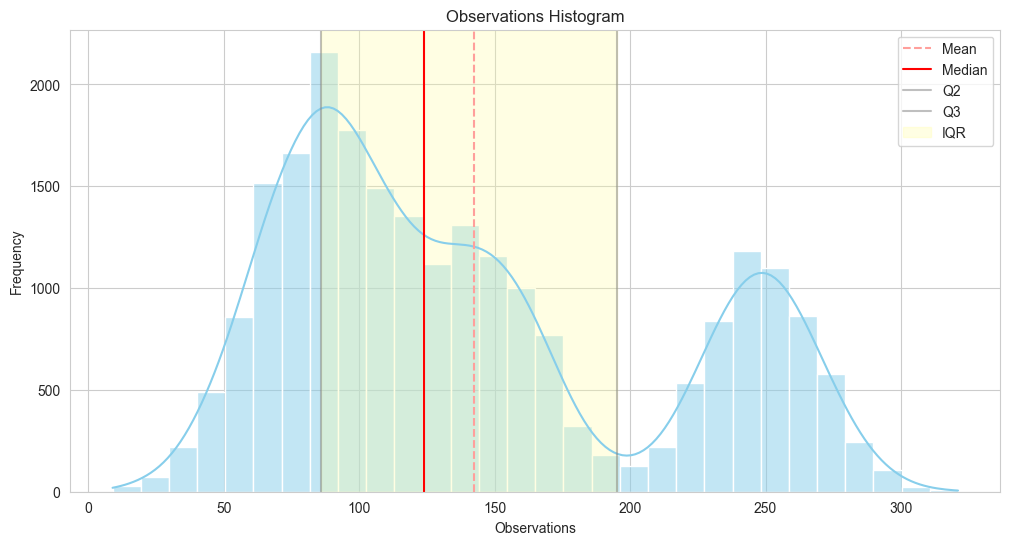

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

mean = np.mean(obs["observations"])
median = np.median(obs["observations"])
q2 = np.quantile(obs["observations"], 0.25)
q3 = np.quantile(obs["observations"], 0.75)
iqr = q3 - q2

sns.histplot(obs['observations'], bins=30, kde=True, color="skyblue")
plt.xlabel("Observations")
plt.ylabel("Frequency")
plt.title("Observations Histogram")
plt.axvline(mean, color='r', linestyle='--', label="Mean")
plt.axvline(median, color='red', linestyle='-', label="Median")
plt.axvline(q2, color='grey', linestyle='-', label="Q2", alpha=0.5)
plt.axvline(q3, color='grey', linestyle='-', label="Q3", alpha=0.5)
plt.axvspan(q2, q3, color='y', alpha=0.3, label="IQR")
plt.legend()
plt.show()

*The Histogram shows two distinct peaks, with a right skew. For further analysis it will be beneficial to define two subgroups*

- To do this, I will begin by exploring the value counts for each park
- I will then look at the values within the IQR to visualise the distribution
- I will create box plots for each park to visualise potential relationships
- Finally I will determine two subgroups from the data to analyse together in order to extract insight

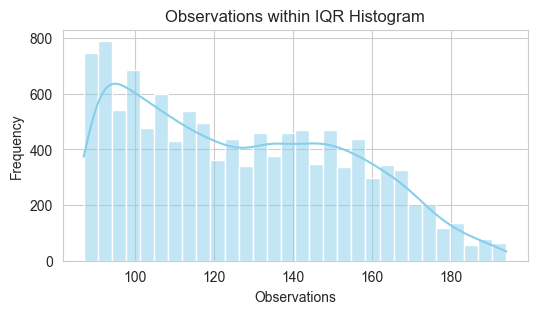

In [11]:
iqr_df = obs[(obs["observations"] > q2) & (obs["observations"] < q3)]

# iqr_df["observations"].describe()
sns.set_style("whitegrid")
plt.figure(figsize=(6, 3))

sns.histplot(iqr_df['observations'], bins=30, kde=True, color="skyblue")
plt.xlabel("Observations")
plt.ylabel("Frequency")
plt.title("Observations within IQR Histogram")
plt.show()


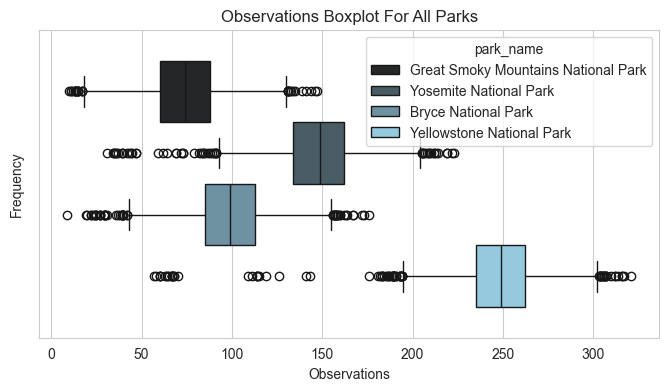

In [12]:
#Value counts for the observations column

# Set Seaborn style
sns.set_style("whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Boxplot
sns.boxplot(data=obs, x="observations", palette='dark:skyblue', hue="park_name", ax=ax)



# Set labels and title
ax.set(xlabel="Observations", ylabel="Frequency")
plt.title("Observations Boxplot For All Parks")

# Show the plot
plt.show()




*By plotting each parks box plot, we can see that the Yellowstone National Park is attributed to the second peak and is infact a subgroup within the data*

*As this park contributes to many of the observations, like the plant species, it may be helpful to analyse this separately*

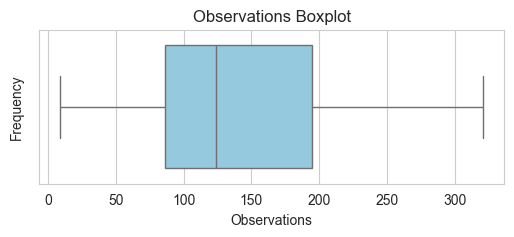

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 2))

sns.boxplot(data=obs, x="observations", color="skyblue")
plt.xlabel("Observations")
plt.ylabel("Frequency")
plt.title("Observations Boxplot")
plt.show()


*We can confirm that the general observations sit between the 100 and 200 range. With a tendency leaning toward 100 where we know most of the park data is from. This confirms that Yellowstone has a big pull on our data.*

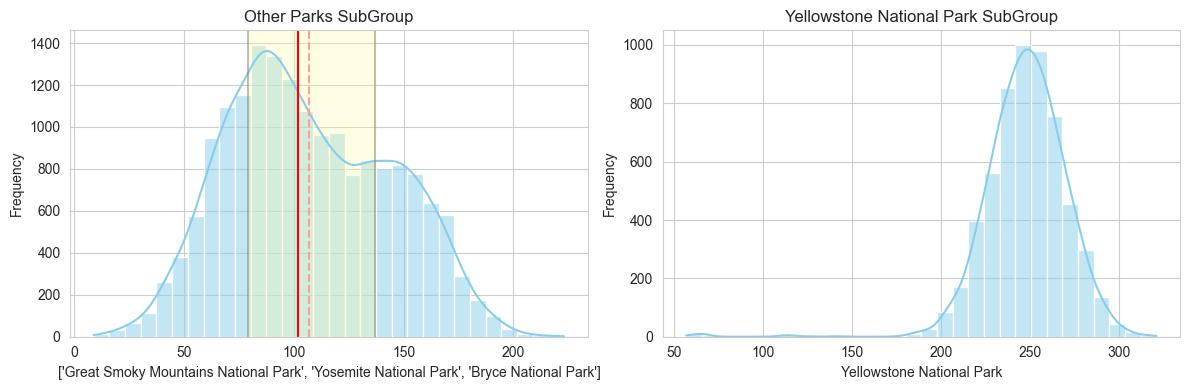

In [14]:
other_parks = obs[obs["park_name"] != "Yellowstone National Park"]
yellowstone = obs[obs["park_name"] == "Yellowstone National Park"]

park_names = other_parks["park_name"].unique().tolist()

mean = np.mean(other_parks["observations"])
median = np.median(other_parks["observations"])
q2 = np.quantile(other_parks["observations"], 0.25)
q3 = np.quantile(other_parks["observations"], 0.75)
iqr = q3 - q2

#Plot means, median, and iqrs for each group

sns.set_style("whitegrid")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(other_parks['observations'], bins=30, kde=True, color="skyblue")
plt.xlabel([park for park in park_names])
plt.ylabel("Frequency")
plt.title("Other Parks SubGroup")
plt.axvline(mean, color='r', linestyle='--', label="Mean")
plt.axvline(median, color='red', linestyle='-', label="Median")
plt.axvline(q2, color='grey', linestyle='-', label="Q2", alpha=0.5)
plt.axvline(q3, color='grey', linestyle='-', label="Q3", alpha=0.5)
plt.axvspan(q2, q3, color='y', alpha=0.3, label="IQR")

plt.subplot(1, 2, 2)
sns.histplot(yellowstone['observations'], bins=30, kde=True, color="skyblue")
plt.xlabel("Yellowstone National Park")
plt.ylabel("Frequency")
plt.title("Yellowstone National Park SubGroup")
plt.tight_layout()
plt.show()


*From this we can see that the three parks have the highest frequency combined. However, it might be useful to see the distribution of the three to understand the values/proportions of each*

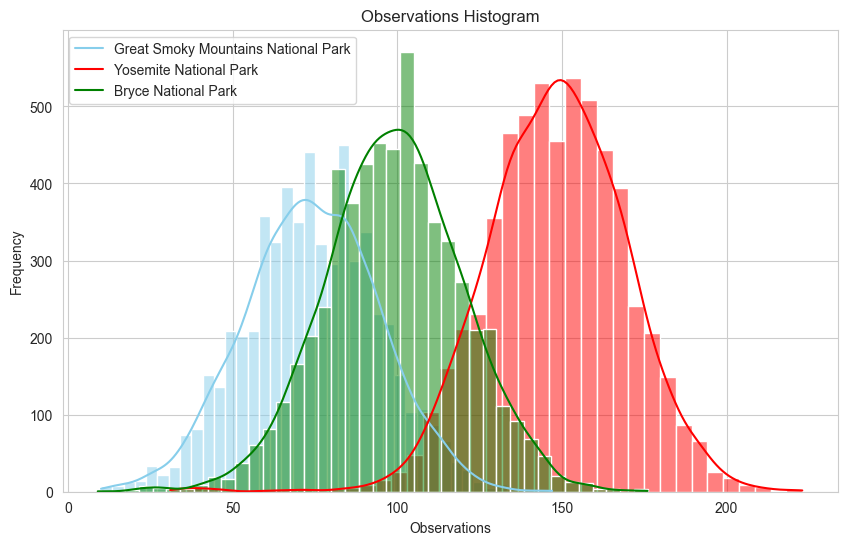

In [15]:
great_smoky = obs[obs["park_name"] == "Great Smoky Mountains National Park"]
yosemite = obs[obs["park_name"] == "Yosemite National Park"]
bryce = obs[obs["park_name"] == "Bryce National Park"]

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(great_smoky['observations'], bins=40, kde=True, color="skyblue")
sns.histplot(yosemite['observations'], bins=40, kde=True, color="red")
sns.histplot(bryce['observations'], bins=40, kde=True, color="green")
plt.xlabel("Observations")
plt.ylabel("Frequency")
plt.title("Observations Histogram")
plt.legend(["Great Smoky Mountains National Park", "Yosemite National Park", "Bryce National Park"])
plt.show()


*When breaking down the data by park, we can see how it might be more beneficial to treat each park as a distinct group and analyse separately*

- Of the three other parks, Bryce makes up the middle of the data, with Yosemite representing the higher end frequency of the data.

*For now we will analyse the data using the parks as separate groups*

- I will left join the two tables to bring the species and edangered lists in as columns
- Using this, I will analyse this data by park to derive insight about each park

In [16]:
bio = pd.merge(obs, species, on="scientific_name", how="left")

bio[bio["scientific_name"] == "Vicia benghalensis"]

,scientific_name,park_name,observations,category,common_names,conservation_status
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",No Status
11517,Vicia benghalensis,Yosemite National Park,148,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",No Status
13756,Vicia benghalensis,Yellowstone National Park,247,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",No Status
17101,Vicia benghalensis,Bryce National Park,104,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",No Status


*Now we have the combined data, I will explore the data further:*

- I will look at how observations for each park are distributed by category
- Then I will look at each park and the distribution of categories and conservation status more detailed
- Finally I will take an in depth look at a particular category and draw some correlations from the data

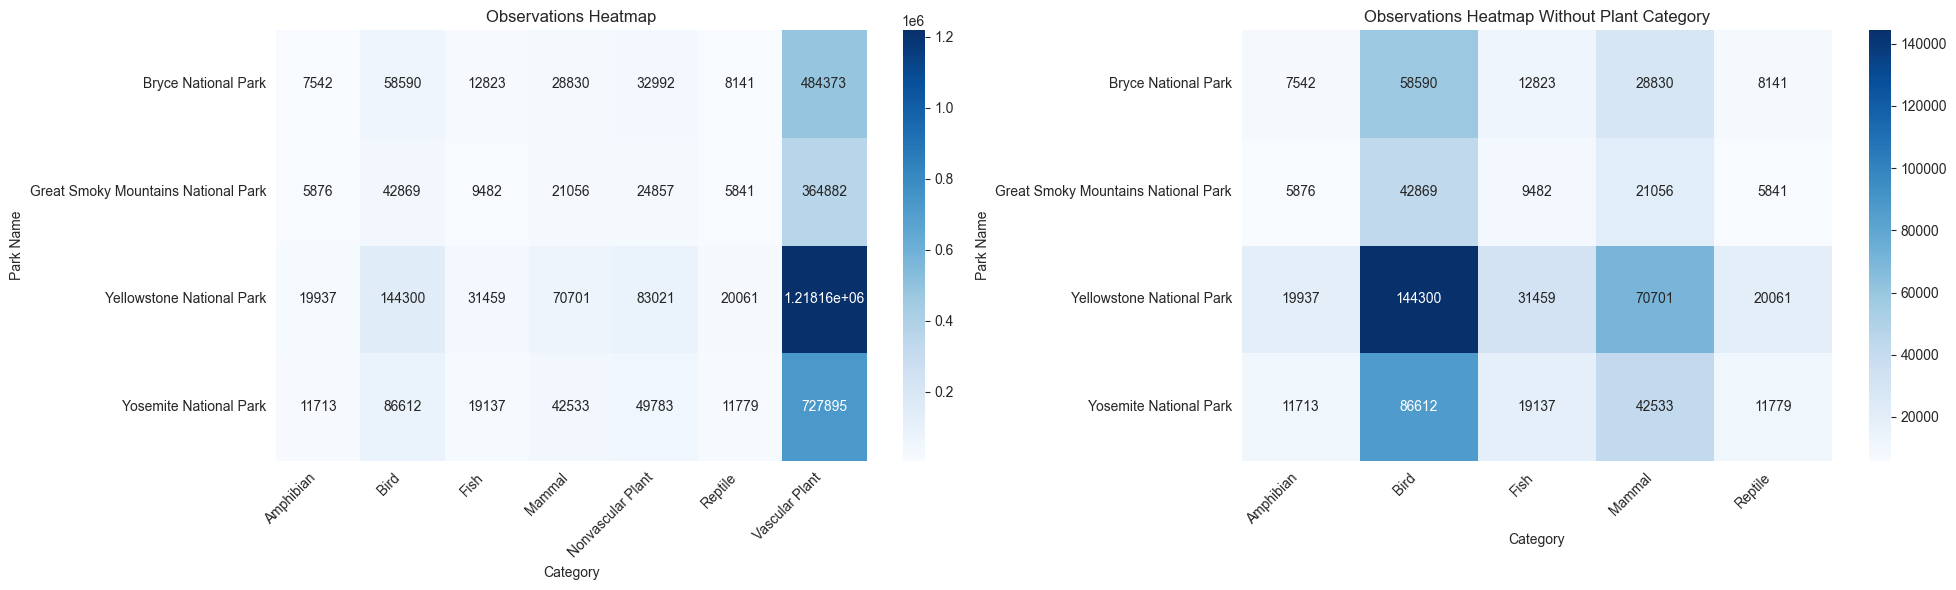

In [17]:
park_obs = bio.groupby(["park_name", "category"]).sum()["observations"].unstack().fillna(0)
park_obs_no_plant = park_obs.drop(["Vascular Plant", "Nonvascular Plant"], axis=1)
park_obs

#Plot a heatmap of the park_obs dataframe

sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.heatmap(park_obs, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Category")
plt.ylabel("Park Name")
plt.title("Observations Heatmap")
#Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.heatmap(park_obs_no_plant, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Category")
plt.ylabel("Park Name")
plt.title("Observations Heatmap Without Plant Category")
#Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



*Looking at the heatmaps, there seems to be a high frequency of Birds and Mammals ditrubuted between the parks, with Yellowstone commanding the most*

- It may be helpful to understand the proportions of birds and mammals in each park to understand why
- From there, I will look at the endangered status and at correlations between number of observations and endangered status for each category
- Finally I will look at proportions of endangered status observed between the parks


In [18]:
#Looking at correalation between observations and endangered status
park_endangered = bio[(bio["category"] != "Vascular Plant") & (bio["category"] != "Nonvascular Plant") & (bio["conservation_status"] != "No Status")]

#Creating a crosstab between observations and endangered status
obs_endangered = pd.crosstab(park_endangered["observations"], park_endangered["conservation_status"])
obs_endangered

chi2, p, _, _ = chi2_contingency(obs_endangered)

chi2, p


(808.9961445842441, 1.3869982470881066e-07)

In [19]:
park_endangered = bio[(bio["category"] != "Vascular Plant") & (bio["category"] != "Nonvascular Plant") & (bio["conservation_status"] != "No Status")]

result = park_endangered.groupby(["park_name", "category", "conservation_status"]).sum()["observations"].unstack().fillna(0)
result




conservation_status                            Endangered  In Recovery  \
park_name                           category                             
Bryce National Park                 Amphibian        31.0          0.0   
                                    Bird             98.0        258.0   
                                    Fish             70.0          0.0   
                                    Mammal          395.0        130.0   
                                    Reptile           0.0          0.0   
Great Smoky Mountains National Park Amphibian        11.0          0.0   
                                    Bird             61.0        189.0   
                                    Fish             77.0          0.0   
                                    Mammal          217.0         59.0   
                                    Reptile           0.0          0.0   
Yellowstone National Park           Amphibian        60.0          0.0   
                                    Bird            243.0        559.0   
                                    Fish            202.0          0.0   
                                    Mammal          990.0        330.0   
                                    Reptile           0.0          0.0   
Yosemite National Park              Amphibian        42.0          0.0   
                                    Bird            172.0        386.0   
                                    Fish            106.0          0.0   
                                    Mammal          576.0        196.0   
                                    Reptile           0.0          0.0   

conservation_status                            Species of Concern  Threatened  
park_name                           category                                   
Bryce National Park                 Amphibian               387.0        80.0  
                                    Bird                   7252.0         0.0  
                                    Fish                    339.0       322.0  
                                    Mammal                 4086.0        90.0  
                                    Reptile                 387.0         0.0  
Great Smoky Mountains National Park Amphibian               249.0        73.0  
                                    Bird                   5047.0         0.0  
                                    Fish                    268.0       202.0  
                                    Mammal                 2591.0        84.0  
                                    Reptile                 365.0         0.0  
Yellowstone National Park           Amphibian               852.0       255.0  
                                    Bird                  17724.0         0.0  
                                    Fish                    955.0       718.0  
                                    Mammal                 9452.0       258.0  
                                    Reptile                1100.0         0.0  
Yosemite National Park              Amphibian               556.0       156.0  
                                    Bird                  10735.0         0.0  
                                    Fish                    547.0       403.0  
                                    Mammal                 5546.0       146.0  
                                    Reptile                 684.0         0.0

*Using this data, we can see that Mammals are the most endangered species. While Fish experience the greatest threat. And, there is a huge concern for both Birds and Mammals*

- Moving forward into the last stages of analysis, I will look at the most endangered animals focusing on Mammals
- I will look at what types of animals are the most endangered that are Mammals and in which parks
- Lastly, I will highlight the animal with the most observations that is endangered

In [28]:

bio["Name"] = bio.apply(lambda row: row["common_names"].split(" ")[-1], axis=1)

mammal = bio[bio["category"] == "Mammal"]

mammal_endangered = mammal[mammal["conservation_status"] == "Endangered"]

mammal_endangered["Name"].value_counts()


Name
Wolf        28
Myotis       8
Sheep        4
Squirrel     4
Name: count, dtype: int64

*From this data we see that Wolves are among the most endangered species of Mammal*

- I will explore further by looking at the number of observations
- I will also look at the data by park

In [34]:
mammal_endangered.groupby(["Name", "park_name"]).sum()["observations"].unstack().fillna(0)




park_name,Bryce National Park,Great Smoky Mountains National Park,Yellowstone National Park,Yosemite National Park
Name,,,,
Myotis,54,40,136,75
Sheep,22,25,67,39
Squirrel,29,21,67,36
Wolf,290,131,720,426


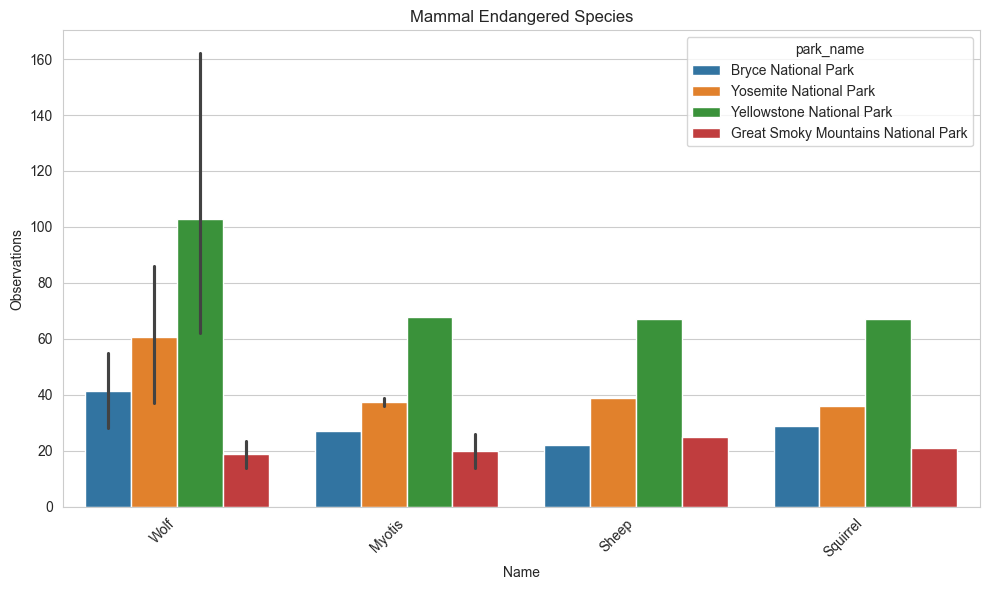

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=mammal_endangered, x="Name", y="observations", hue="park_name")
plt.xlabel("Name")
plt.ylabel("Observations")
plt.title("Mammal Endangered Species")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()